## This is an implementation of an FFT on a song
The inspiration for this implementation came from http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [11]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft, dct
from scipy.io import wavfile
from scipy.signal import blackman, hanning, hamming
import numpy as np
from scipy import signal

%matplotlib inline

# Location of the song
#files_location = "/Users/valentin/Documents/MusicEngine/wav/TARGET_Biz_Amulet.wav"
#files_location = "/Users/valentin/GoogleDrive/dt_16bars_102rap.wav"
files_location = "C:/Users/bre49823/GoogleDrive/MusicEngine/wav/TARGET_Biz_Amulet.wav"

### Read in the data and create a plot of the raw audio file
The raw data is in the time domain and using Fourier transform I'll convert it to frequency spectrum

In [12]:
# Read in the raw audio data and get the sample rate (in samples/sec)
sample_rate, soundtrack_data = wavfile.read(files_location)
audio_data = soundtrack_data.T[0]                     # this is a two channel soundtrack, get only one of the tracks
audio_data = audio_data[0:int(2 * sample_rate)]      # keep only the first 10 seconds

time = np.arange(0, float(audio_data.shape[0]), 1) / sample_rate

In [13]:
print(audio_data.shape, time.shape)

(96000,) (96000,)


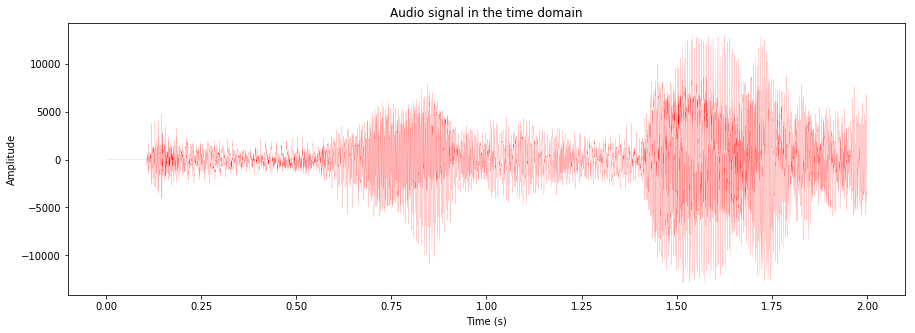

In [14]:
# Plot the raw signal - amplitude (or loudness) over time
plt.figure(figsize = (15, 5))
plt.plot(time, audio_data, linewidth = 0.1, alpha = 2, color='#ff0000')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Audio signal in the time domain")

### Apply pre-emphasis filter to the raw audio data
This makes the signal cleaner with less noise. It is done to balance the frequency spectrum since high frequencies have lower magnitude than lower frequncies.
<br>
The pre-emphasis filter is y(t) = x(t) - emphasis_coeff * (t - 1)
<br>
Typical values for the emphasis coefficients are 0.95 and 0.97

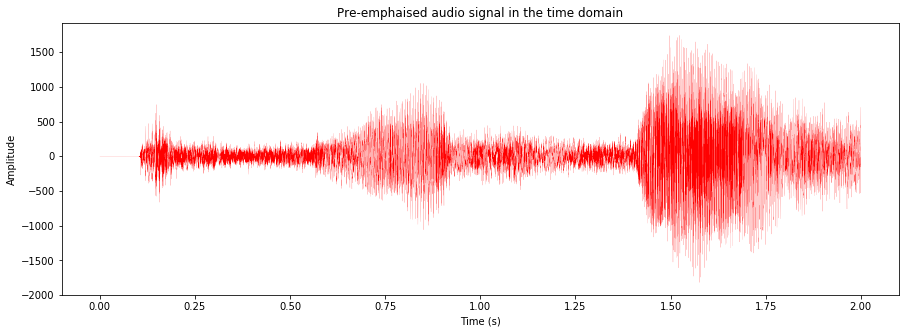

In [15]:
# Apply pre-emphasis filter
emphasis_coeff = 0.95
emphasized_audio_data = np.append(audio_data[0], audio_data[1:] - emphasis_coeff * audio_data[:-1])

# Plot the emphasized signal
plt.figure(figsize = (15, 5))
plt.plot(time, emphasized_audio_data, linewidth = 0.1, alpha = 2, color='#ff0000')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Pre-emphaised audio signal in the time domain")

### Split the audio data into frames
When we apply Fourier transform it needs to be applied over short chunks of the raw audio data. The frequencies in the audio signal change over time, and if we do the transformation using the whole length of the song, we would lose these changes in frequencies.
<n>
The frames need to be overlapping. According to Haytham Fayek (http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html), frame sizes for speech processing range from 20ms to 40ms with 50%(+/-10%) overlap between consecutive frames.
<n>
I'll use 25ms for the frame size and 15ms overlap. The difference between the frame length and the overlap is called a stride (i.e. stride = frame length - overlap)

In [16]:
frame_size = 0.025
frame_overlap = 0.015

audio_signal = audio_data

# Calculate the length of each frame and the step for moving forward the FFT
frame_stride = round(frame_size - frame_overlap, 3)
frame_length, frame_step = int(round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))

# Calculate the total number of frames
signal_length = len(audio_signal)
number_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

# Pad the raw signal data with zeros to make sure that all frames have equal number of samples
pad_audio_length = number_frames * frame_step + frame_length          # This number should be very close to the audio signal length. The difference is caused by the rounding in the calculation of number_frames
zeros_vector = np.zeros((pad_audio_length + signal_length))
pad_signal = np.append(audio_signal, zeros_vector)

# Validation of the data
print (frame_stride, frame_length, frame_step, signal_length, number_frames)
print (signal_length, pad_audio_length, zeros_vector.shape, pad_signal.shape)

0.01 1200 480 96000 198
96000 96240 (192240,) (288240,)


In [17]:
int(np.ceil(float(np.abs(signal_length - frame_length)))) / frame_step

197.5

In [18]:
# frames_idx[] is just an array index which is used to split the pad_signal[] array
frames_idx = np.tile(np.arange(0, frame_length), (number_frames, 1)) + np.tile(np.arange(0, number_frames * frame_step, frame_step), (frame_length, 1)).T 
signal_frames = pad_signal[frames_idx.astype(np.int32 , copy = False)]

print (signal_frames.shape, frames_idx.shape)
signal_frames[1, 100:110]
#np.savetxt("C:/Users/bre49823/Desktop/signal_frames_before_hamming.csv", signal_frames, delimiter = ",")

(198, 1200) (198, 1200)


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

### Create a window function for the Fourier transform
_(source of pictures: http://www.opentextbooks.org.hk/ditatopic/9759)_
<p>
The windows are used for smoothing values of the raw signal in each time frame. The window function (e.g. Hamming) shrinks the vales of raw signal at the ends of a window which also reduces spectral leakage (i.e. performing anti alising)
<br>

There are three widely used windows in the DSP literature - Hanning, Hamming and Blackman:
###### Hamming window
$$w(n) = 0.54 - 0.46\cos\frac{2\pi n}{N - 1}, where\  0 <= n <= N - 1$$
###### Hanning window
$$w(n) = 0.5 - 0.5\cos\frac{2\pi n}{N - 1}, where\  0 <= n <= N - 1$$
###### Blackman window
$$w(n) = 0.42 - 0.5\cos\frac{2\pi n}{N} + 0.08\cos\frac{4\pi n}{N}$$

_(More can be found here https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.window.html)_


<br>
###### Rectangular window includes additional periods at the beginning and end of the time frames and causes spectral leakage
Using a rectangular window includes more time periods at the beginning and end of a window, which creates spectral leakage. Also when using a rectangular window the Fourier transform produces a noisy spectrogram. That's why we need to use on the windows discussed above - Hamming, Hanning or Blackman.
![title](files/spectrogram_hanning_vs_rectangular.png)
###### Fourier transform should be calculated using overlapping windows
The windowing functions discussed here are tapered at the ends, which modulates the amplitudes and creates sin wave type of a signal. This can be seen on the picture below. Therefore, the windows need to be overlapped.
![title](files/spectrogram_with_non_overlapping_windows.png)
###### Spectrogram with overlapping windows
To alleviate the modulated amplitude of the raw signal, frames are overlapped (typically by half a frame duration). This solution requires more Fourier transform calculations than needed by rectangular windowing, but the spectra are much better behaved and spectral changes are much better captured.
![title](files/spectrogram_with_overlapping_windows.png)

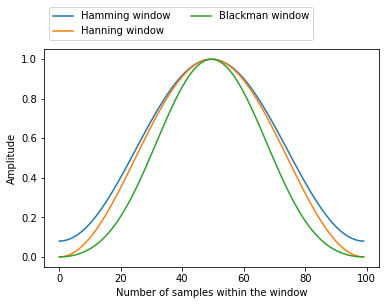

In [19]:
# Plot sample windows with frame_length = 200
# Populate windows are Hamming, Hanning and Blackman - I'll use a Hamming window
plt.plot(np.hamming(100), label = "Hamming window")
plt.plot(np.hanning(100), label = "Hanning window")
plt.plot(np.blackman(100), label = "Blackman window")
plt.ylabel("Amplitude")
plt.xlabel("Number of samples within the window")
plt.legend(bbox_to_anchor = (0., 1.02, 1., .102), loc = 0, ncol = 2)

In [20]:
# The extraction of the signal at time Y(t) = (value of the signal at time t) * (value of the window at times t)
signal_frames *= np.hamming(frame_length)      # The length of each frame is (frame_size * sample_rate)

print (signal_frames.shape, frame_length)
signal_frames[1, 100:110]

#np.savetxt("C:/Users/bre49823/Desktop/signal_frames_after_hamming.csv", signal_frames, delimiter = ",")

(198, 1200) 1200


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

### Calculate Fourier transformation
The input audio data is in the time domain, and using Discrete Fourier Transform, we can transform it from the time to the frequency domain. The actual implementation of DFT is called Fast Fourier Transformation (FFT). The FFT will be applied to each frame using a windowing function.
<p>
The result of the Fourier transform is a sequence of real and complex numbers, of which we only need the real part.
<p>
In addition to the Fourier transformation, computer the power spectrum of the signal.

In [21]:
# Calculate FFT
# The FFT is symmetrical, and by using "np.fft.rfft" we only take the first half automatically. Otherwise, if we use "np.fft.fft" we'll need to take the first half only
n_fft = 512
signal_fft_transform = np.fft.rfft(signal_frames, n = n_fft)
signal_fft_transform_abs = np.absolute(signal_fft_transform)

# Calculate the power for each frame
signal_power = ((signal_fft_transform_abs ** 2) / n_fft)

print(signal_fft_transform_abs.shape, signal_power.shape)
#np.savetxt("C:/Users/bre49823/Desktop/signal_frames_fft_transform_abs.csv", signal_fft_transform_abs.T, delimiter = ",")
#np.savetxt("C:/Users/bre49823/Desktop/signal_power.csv", signal_power, delimiter = ",")

(198, 257) (198, 257)


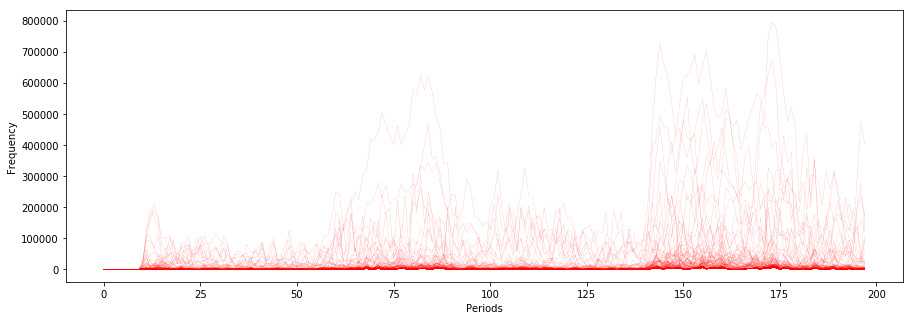

In [22]:
# Line plot of the Fourier transform
plt.figure(figsize = (15, 5))
plt.plot(signal_fft_transform_abs,
         linewidth = 0.08, alpha = 3, color = '#ff0000') 
plt.xlabel("Periods")
plt.ylabel("Frequency")

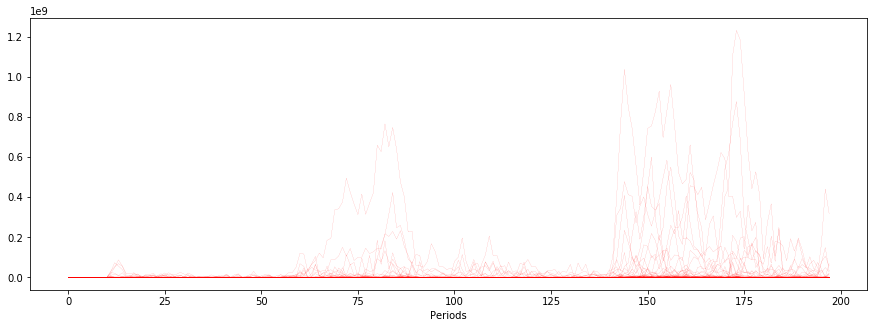

In [23]:
# Line plot of the power spectrum
plt.figure(figsize = (15, 5))
plt.plot(signal_power,
         linewidth = 0.08, alpha = 3, color = '#ff0000')
plt.xlabel("Periods")

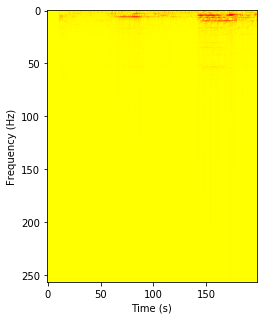

In [24]:
# Plot spectrogram
plt.figure(figsize = (15, 5))
plt.imshow(signal_fft_transform_abs.T, cmap = plt.get_cmap('autumn_r'))
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

C:\Users\bre49823\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\matplotlib\axes\_axes.py:7235: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


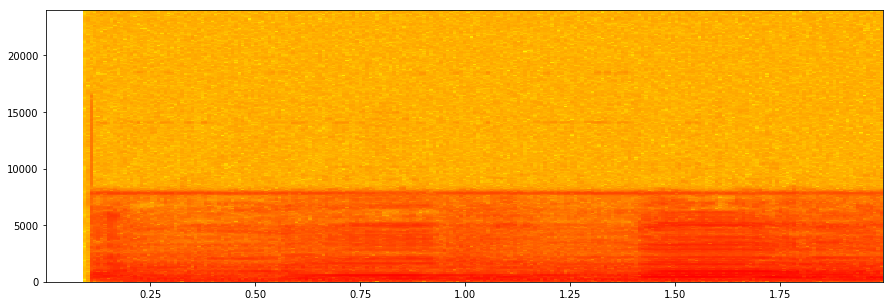

In [25]:
# Plot spectrogram using the spectrogram method
plt.figure(figsize = (15, 5))
Pxx, freqs, bins, im = plt.specgram(audio_signal,
                                    Fs = sample_rate,
                                    NFFT = 512,
                                    #window = window_hanning(),
                                    cmap = plt.get_cmap('autumn_r'))

### Convert to Mel-scale
In the following section we'll extract the Mel frequency cepstral coefficients (MFCC) which are unique features of acoustic signals. At the end we'll have a set of 24 unique features (12 MFCC and 12 deltas)
<p>
The process for doing this is roughly the following:
<br>
1) Create logarithmic filter banks
<br>
2) Aggregate the power spectrum calculated with DFT into the filter banks
<br>
3) Calculate the MFCCs by taking the Discrete Cosine Transform (DCT) of the filter banks
<br>
4) Calculate the Delta coefficients
<br>
5) Calculate the Delta-Delta coefficients

In [57]:
# 1) Create logarithmic filter banks
# 2) Aggregate the power spectrum calculated with DFT into the filter banks
num_filters = 20         # try higher values, perhaps 40

mel_scale_min = 0
mel_scale_max = (2595 * np.log10(1 + (sample_rate / 2) / 700))
mid_mel_points = np.linspace(mel_scale_min, mel_scale_max, num_filters + 2) # we add 2 more points for the mel bins

hertz = (700 * (10 ** (mid_mel_points / 2595) - 1))

# Convert frequencies to FFT bin numbers
# The final bank should be close to (or the same) as the number of points from the FFT
bin_sizes = np.floor((n_fft + 1) * hertz / sample_rate)

In [58]:
fbank = np.zeros((num_filters, int(np.floor(n_fft / 2 + 1))))
for j in range(1, nfilt + 1):
    filter_bank_prior = int(bin[j - 1])   # left
    filter_bank_center = int(bin[j])             # center
    filter_bank_next = int(bin[j + 1])    # right
    
    for k in range(filter_bank_prior, filter_bank_center):
        fbank[j - 1, k] = (k - bin[j - 1]) / (bin[j] - bin[j - 1])
    for k in range(filter_bank_center, filter_bank_next):
        fbank[j - 1, k] = (bin[j + 1] - k) / (bin[j + 1] - bin[j])

filter_banks = np.dot(signal_power, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks)

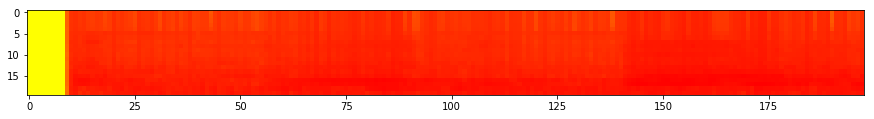

In [72]:
# Spectrogram with the MFCCs
plt.figure(figsize = (15, 10))
# plt.imshow(filter_banks.T, cmap = plt.get_cmap('autumn_r'))

plt.imshow(np.flipud(filter_banks.T), cmap = plt.get_cmap('autumn_r'))


In [66]:
# 3) Calculate the MFCCs by taking the Discrete Cosine Transform (DCT) of the filter banks
num_ceps = 12
mfcc = dct(filter_banks, type = 2, axis = 1, norm = 'ortho')[:, 1 : (num_ceps + 1)] # Keep only coefficients 2 - 13 
#print mfcc.shape

# One may apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve
# speech recognition in noisy signals
cep_lifter = 22    # generally used

(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift

In [ ]:
# 4) Calculate the Delta coefficients


In [ ]:
# 5) Calculate the Delta-Delta coefficients
